In [1]:
suppressMessages(library(tidyverse))
library(Seurat) %>% suppressMessages()
library(Signac) %>% suppressMessages()
library(EnsDb.Mmusculus.v79) %>% suppressMessages()
library(BSgenome.Mmusculus.UCSC.mm10) %>% suppressMessages()
library(patchwork) %>% suppressMessages()
library(ggpubr) %>% suppressMessages()
library(Matrix) %>% suppressMessages()
library(ComplexHeatmap) %>% suppressMessages()
library(circlize) %>% suppressMessages() 
library(GenomicRanges) %>% suppressMessages()

library(future) %>% suppressMessages()
plan("multicore",workers=20)

options(future.globals.maxSize  = 8 * 1024 * 1024 * 1024)

## Construct object

In [2]:
# load RNA 
rnamat = read_tsv("../data/RNAmats/counts.gene.total.format.tsv.gz")
rnamat %>% column_to_rownames("gene") -> rnamat

# Create Seurat object
charm = CreateSeuratObject(counts = rnamat, project = "CHARMmesc",assay="rna")

# load atac / ct
cellnames = rownames(charm[[]])
atac_fragments = CreateFragmentObject("../data/fragments/atac.fragments.bgz",cells = cellnames)
ct_fragments = CreateFragmentObject("../data/fragments/ct.fragments.bgz",cells = cellnames)
mm10genome = seqlengths(BSgenome.Mmusculus.UCSC.mm10)
mm10autosomes = mm10genome[1:19]

atac_count_matrix = GenomeBinMatrix(atac_fragments, binsize = 5000, genome = mm10autosomes)
ct_count_matrix = GenomeBinMatrix(ct_fragments, binsize = 5000, genome = mm10autosomes)

atac_assay = CreateChromatinAssay(counts = atac_count_matrix, fragments = atac_fragments,genome="mm10")
ct_assay = CreateChromatinAssay(counts = ct_count_matrix, fragments = ct_fragments,genome="mm10")
charm[["atac"]] = atac_assay
charm[["ct"]] = ct_assay

# add annotations
annotations = GetGRangesFromEnsDb(EnsDb.Mmusculus.v79)
seqlevels(annotations) = paste0("chr",seqlevels(annotations))
genome(annotations) = "mm10"
Annotation(charm[["atac"]]) <- annotations
Annotation(charm[["ct"]]) <- annotations

# calc tss enrichment score
charm = TSSEnrichment(charm, fast=FALSE,region_extension = 2000,assay = "atac")
charm@meta.data %>% dplyr::rename(TSS.enrichment.atac = TSS.enrichment, TSS.percentile.atac = TSS.percentile) -> charm@meta.data
charm = TSSEnrichment(charm, fast=FALSE,region_extension = 2000,assay = "ct")
charm@meta.data %>% dplyr::rename(TSS.enrichment.ct = TSS.enrichment, TSS.percentile.ct = TSS.percentile) -> charm@meta.data

Rows: 41020 Columns: 960
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr   (1): gene
dbl (959): P10001, P10002, P10003, P10004, P10005, P10006, P10007, P10008, P...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
"Data is of class data.frame. Coercing to dgCMatrix."
Computing hash

Computing hash

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels

In [3]:
pairs_meta = read_tsv("./cc_metadata.tsv")

Rows: 958 Columns: 9
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (3): pairs, cellname, NaganoCellcycle
dbl (6): order_index, near_p, mitotic_p, farAvg, repli_score, annote_ratio

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
charm@meta.data %>% dplyr::mutate(cellname = rownames(.)) %>% left_join(pairs_meta,by="cellname") %>%
     mutate(temp = cellname) %>% column_to_rownames("temp") -> charm@meta.data

## CallPeak

In [5]:
macs2_path <- "/home/zliu/miniforge3/envs/charm/bin/macs2"
DefaultAssay(charm) <- "atac"
atac_peaks <- CallPeaks(
    charm,
    assay="atac",
    broad = FALSE,
    macs2.path = macs2_path,
    extsize = 150, 
    effective.genome.size = "mm",
    additional.args = "--shift 0"
)
# DefaultAssay(charm) <- "ct"
# ct_peaks <- CallPeaks(
#   object = charm,  
#   assay = "ct", 
#   macs2.path = macs2_path,
#   broad = TRUE,  
#   extsize = 150,  
#   effective.genome.size = "mm",  
#   additional.args = "--nomodel --nolambda --broad-cutoff 0.1 --bdg --shift 0"
# )

atac_peaks %>% saveRDS("atac_peak.rds")
# ct_peaks %>% saveRDS("ct_peak.rds")

In [6]:
ct_peaks <- read_tsv("../data/publicdata/ENCODE/ENCFF008XKX_encode_mESCBruce4_H3K27me3.bed.gz",col_names = F) %>% dplyr::select(1:3)
# as grange object
ct_peaks %>% dplyr::rename(chr = X1, start = X2, end = X3) %>% mutate(start= start-2000, end = end + 2000) %>% 
  makeGRangesFromDataFrame(keep.extra.columns = T) -> ct_peaks

Rows: 12621 Columns: 10
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (3): X1, X4, X6
dbl (7): X2, X3, X5, X7, X8, X9, X10

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
DefaultAssay(charm) <- "atac"
atac_peaks_counts = FeatureMatrix(
    fragments = Fragments(charm),
    features = atac_peaks,
    cells = colnames(charm)
)
DefaultAssay(charm) <- "ct"
ct_peaks_counts = FeatureMatrix(
    fragments = Fragments(charm),
    features = ct_peaks,
    cells = colnames(charm)
)

annotations = GetGRangesFromEnsDb(EnsDb.Mmusculus.v79)
seqlevels(annotations) = paste0("chr",seqlevels(annotations))
genome(annotations) = "mm10"

charm[["atac_peaks"]] <- CreateChromatinAssay(
    counts=atac_peaks_counts,
    fragments = "../data/fragments/atac.fragments.bgz",
    annotation = annotations
)
charm[["ct_peaks"]] <- CreateChromatinAssay(
    counts=ct_peaks_counts,
    fragments = "../data/fragments/ct.fragments.bgz",
    annotation = annotations
)

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects h

## QC

In [8]:
options(repr.matrix.max.rows=6, repr.matrix.max.cols=50)
charm@meta.data %>% head()

,orig.ident,nCount_rna,nFeature_rna,nCount_atac,nFeature_atac,nCount_ct,nFeature_ct,TSS.enrichment.atac,TSS.percentile.atac,TSS.enrichment.ct,TSS.percentile.ct,cellname,pairs,order_index,near_p,mitotic_p,farAvg,NaganoCellcycle,repli_score,annote_ratio,nCount_atac_peaks,nFeature_atac_peaks,nCount_ct_peaks,nFeature_ct_peaks
,<fct>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>
P10001,CHARMmesc,15803,5527,71981,58348,132809,98855,3.746121,0.69,0.9614813,0.10,P10001,/mnt/zliu_ssd/CHARM/CHARM_mesc/data/pairs/P10001.pairs.gz,447,0.6369906,0.1307784,34744797,early/mid-S,0.5735212,0.9936608,12790,10318,6592,4365
P10002,CHARMmesc,15513,5461,41270,35076,97664,75815,3.895179,0.77,1.0061651,0.28,P10002,/mnt/zliu_ssd/CHARM/CHARM_mesc/data/pairs/P10002.pairs.gz,796,0.4719175,0.1825673,23605175,G1,0.4737177,0.9920386,7813,6559,5191,3608
P10003,CHARMmesc,17669,5653,50032,41098,105944,82207,3.452676,0.47,1.1333065,0.88,P10003,/mnt/zliu_ssd/CHARM/CHARM_mesc/data/pairs/P10003.pairs.gz,348,0.6221290,0.1389822,28213782,G1,0.5341537,0.9925697,10110,8236,5500,3812
P10004,CHARMmesc,20129,6085,52433,43563,109902,85396,3.739884,0.68,1.0836309,0.70,P10004,/mnt/zliu_ssd/CHARM/CHARM_mesc/data/pairs/P10004.pairs.gz,331,0.6390573,0.1290690,28640305,early/mid-S,0.5793138,0.9935000,10134,8225,5875,4004
P10005,CHARMmesc,19544,6163,53016,44461,99965,79050,4.005830,0.84,1.1047776,0.79,P10005,/mnt/zliu_ssd/CHARM/CHARM_mesc/data/pairs/P10005.pairs.gz,99,0.6938463,0.1120368,26855134,early/mid-S,0.5740944,0.9930142,11112,9248,5632,4088
P10006,CHARMmesc,16437,5468,46244,39434,84793,67800,3.819650,0.72,0.9659476,0.12,P10006,/mnt/zliu_ssd/CHARM/CHARM_mesc/data/pairs/P10006.pairs.gz,744,0.4979811,0.1685695,25793259,G1,0.4792790,0.9922355,7586,6418,4927,3536


In [9]:
charm@meta.data %>% mutate(FRiP_atac = nCount_atac_peaks / nCount_atac,
                           FRiP_ct = nCount_ct_peaks / nCount_ct) -> charm@meta.data

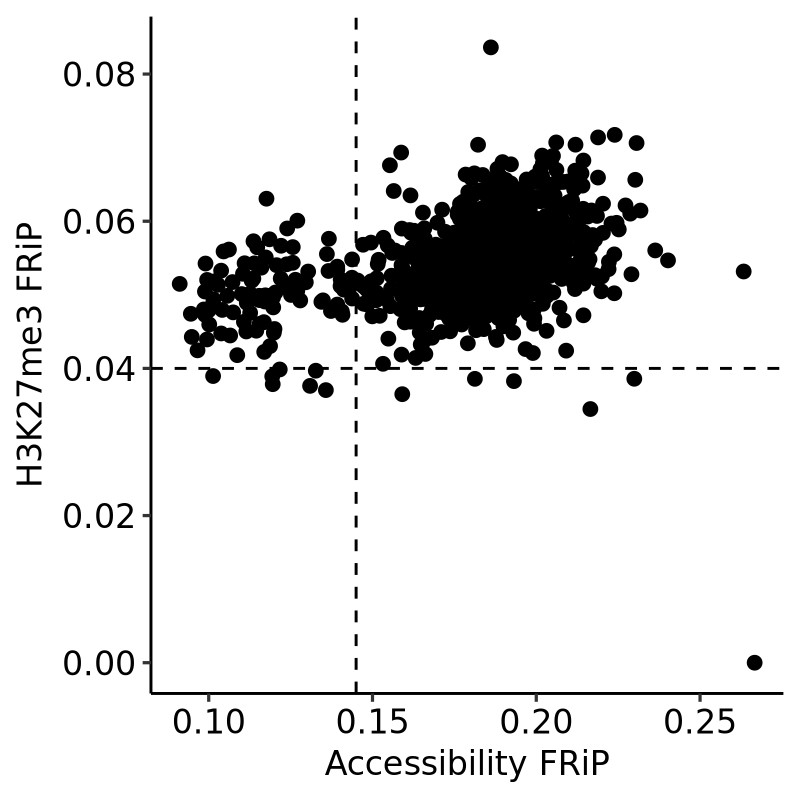

In [10]:
options(repr.plot.height=4,repr.plot.width=4,repr.plot.res=200)
# add horrizontal line at y=0.16 and x= 0.14, dashed
p <- charm@meta.data %>% ggscatter(x="FRiP_atac",y="FRiP_ct") + 
    geom_hline(yintercept = 0.04, linetype = "dashed") +
    geom_vline(xintercept = 0.145, linetype = "dashed") +
    xlab("Accessibility FRiP") + ylab("H3K27me3 FRiP") +
    theme_pubr() + theme(legend.position = "none") 
p
p %>% ggsave(filename = "figures/QC_FRiP.svg",width = 4, height = 4)

In [11]:
hicmeta = read_tsv("/sharec/zliu/CHARM/mESC/metadata_raw.tsv")
hicmeta

Rows: 958 Columns: 19
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr  (2): cellname, plate
dbl (17): Rawreads, yperx, raw_pairs, pairs_dedup, pairs_clean1, pairs_clean...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


cellname,plate,Rawreads,yperx,raw_pairs,pairs_dedup,pairs_clean1,pairs_clean2,pairs_clean3,inter_pairs_clean3,1m,200k,50k,20k,10k,5k,pairsPerRead,pairsValidRatio,interPairsRatio
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
P10001,P10,3.906446,0.004906,5785303,2013981,1971126,1953924,1953158,753646,0.0003119244,0.004717165,0.04334526,0.11850338,0.2343898,0.4343095,0.4443148,0.33760686,0.3858602
P10002,P10,21.795782,0.002712,32292652,3137393,2940841,2933515,2932520,906144,0.0002874125,0.008992761,0.01924086,0.05486346,0.1198981,0.2347780,0.4445166,0.09081075,0.3089984
P10003,P10,14.472152,0.003945,22514567,3207949,2893743,2890543,2889467,1080211,0.0004075727,0.009352793,0.08705027,0.12034919,0.2131469,0.3603129,0.4667517,0.12833767,0.3738444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P9094,P9,4.297960,0.004251,6051902,2413991,2371859,2338510,2337567,648106,0.0001739718,0.01146073,0.06238528,0.1654377,0.2835590,0.4705754,0.4224580,0.3862533,0.2772567
P9095,P9,6.020654,0.004000,8262005,2001553,1971279,1946800,1946070,602282,0.1822409859,0.46725832,0.84608848,1.3025724,1.8820534,2.6370429,0.4117178,0.2355445,0.3094863
P9096,P9,13.506946,0.003356,16815018,1906774,1844847,1837259,1836978,825355,0.0073758618,0.02862779,0.28589353,0.1407143,0.2333482,0.4126017,0.3734948,0.1092463,0.4493004


In [12]:
charm@meta.data %>% left_join(hicmeta) %>% mutate(temp=cellname) %>% column_to_rownames("temp") -> charm@meta.data

Joining with `by = join_by(cellname)`


Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_point()`)."


Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_point()`)."


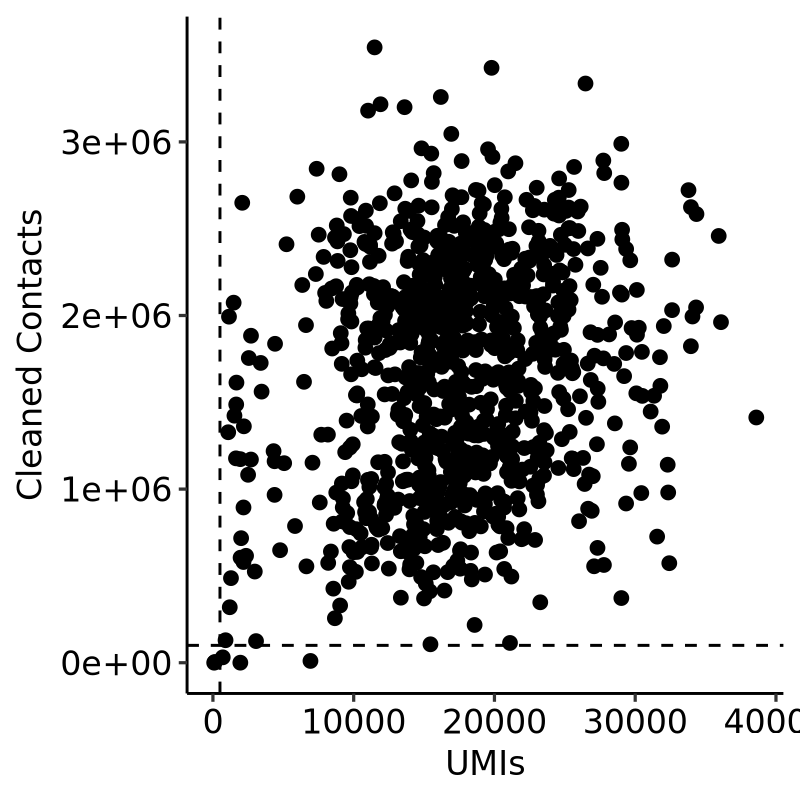

In [13]:
options(repr.plot.height=4,repr.plot.width=4,repr.plot.res=200)
# add horrizontal line at y=0.16 and x= 0.14, dashed
p <- charm@meta.data %>% ggscatter(x="nCount_rna",y="pairs_clean3") + 
    geom_hline(yintercept = 100000, linetype = "dashed") +
    geom_vline(xintercept = 500, linetype = "dashed") +
    xlab("UMIs") + ylab("Cleaned Contacts") +
    theme_pubr() + theme(legend.position = "none") #+
    #scale_y_log2() + scale_x_log2()
p 
p %>% ggsave(filename = "figures/QC_RNA_contacts.svg",width = 4, height = 4)

In [14]:
charm[[]] %>% dplyr::filter(nCount_atac > 2000, nCount_ct > 2000,nCount_rna>500, pairs_clean3 > 100000,FRiP_atac>0.145, FRiP_ct > 0.04,
                                                interPairsRatio < 0.4, nCount_rna > 500,
                                                nCount_ct < 2e5, nCount_atac < 80000) %>% rownames() %>% length()

[1] 805

In [15]:
qcpass_cellnames = charm[[]] %>% dplyr::filter(nCount_atac > 2000, nCount_ct > 2000,nCount_rna>500, pairs_clean3 > 100000,FRiP_atac>0.145, FRiP_ct > 0.04,
                                                interPairsRatio < 0.4, nCount_rna > 500,
                                                nCount_ct < 2e5, nCount_atac < 80000) %>% rownames()
print(length(qcpass_cellnames))
charm = subset(charm,subset = cellname %in% qcpass_cellnames)

[1] 805


## Dim Reduction

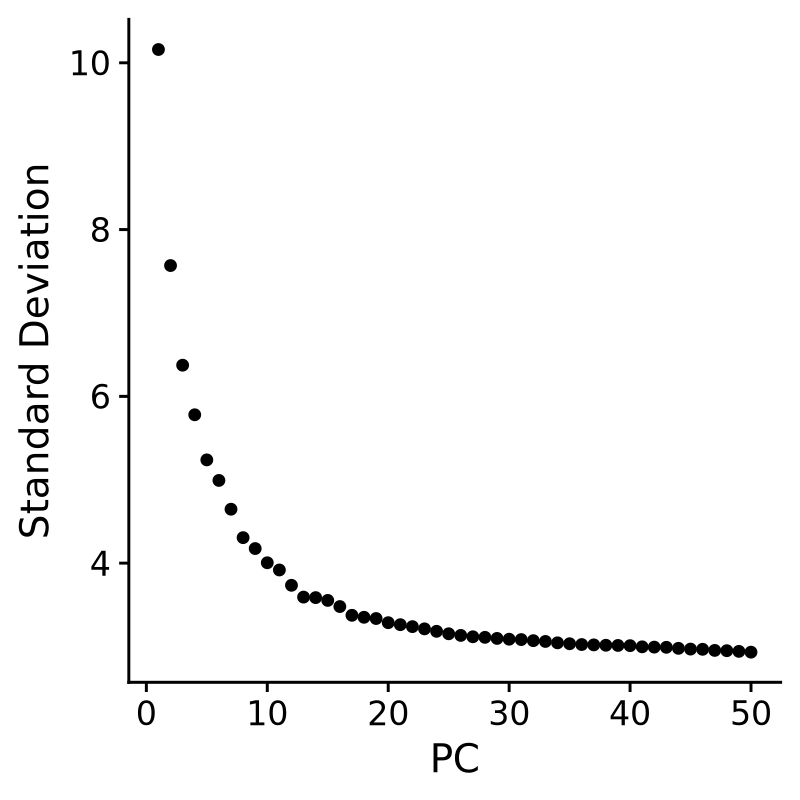

In [16]:
charm %>% SCTransform(verbose=FALSE,assay="rna") %>% RunPCA(verbose=FALSE,reduction.name="pca_rna") -> charm
options(repr.plot.width=4, repr.plot.height=4,repr.plot.res=200)
ElbowPlot(charm,ndims=50,reduction="pca_rna")

In [17]:
charm = RunUMAP(charm, reduction = "pca_rna", dims = 1:10, verbose = FALSE,reduction.name = "umap_rna")
charm = FindNeighbors(charm, reduction = "pca_rna", dims = 1:10, verbose = FALSE)
charm = FindClusters(charm, verbose = FALSE)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"


Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

Warning message:
"UNRELIABLE VALUE: One of the 'future.apply' iterations ('future_lapply-1') unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore"."


In [18]:
# dim reduction and umap for atac
DefaultAssay(charm) <- "atac"
charm <- RunTFIDF(charm)
charm <- FindTopFeatures(charm, min.cutoff = 'q0')
charm <- RunSVD(object = charm,reduction.name = "lsi_atac")
charm = RunUMAP(charm, reduction = "lsi_atac", dims = 2:10, verbose = FALSE,reduction.name = "umap_atac")

DefaultAssay(charm) <- "ct"
charm <- RunTFIDF(charm)
charm <- FindTopFeatures(charm, min.cutoff = 'q0')
charm <- RunSVD(object = charm,reduction.name = "lsi_ct")
charm = RunUMAP(charm, reduction = "lsi_ct", dims = 2:10, verbose = FALSE,reduction.name = "umap_ct")

Performing TF-IDF normalization



Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
"Some features contain 0 total counts"
Running SVD

Scaling cell embeddings

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
"Some features contain 0 total counts"
Running SVD

Scaling cell embeddings

Warning message:
"Key 'LSI_' taken, using 'lsict_' instead"
Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'



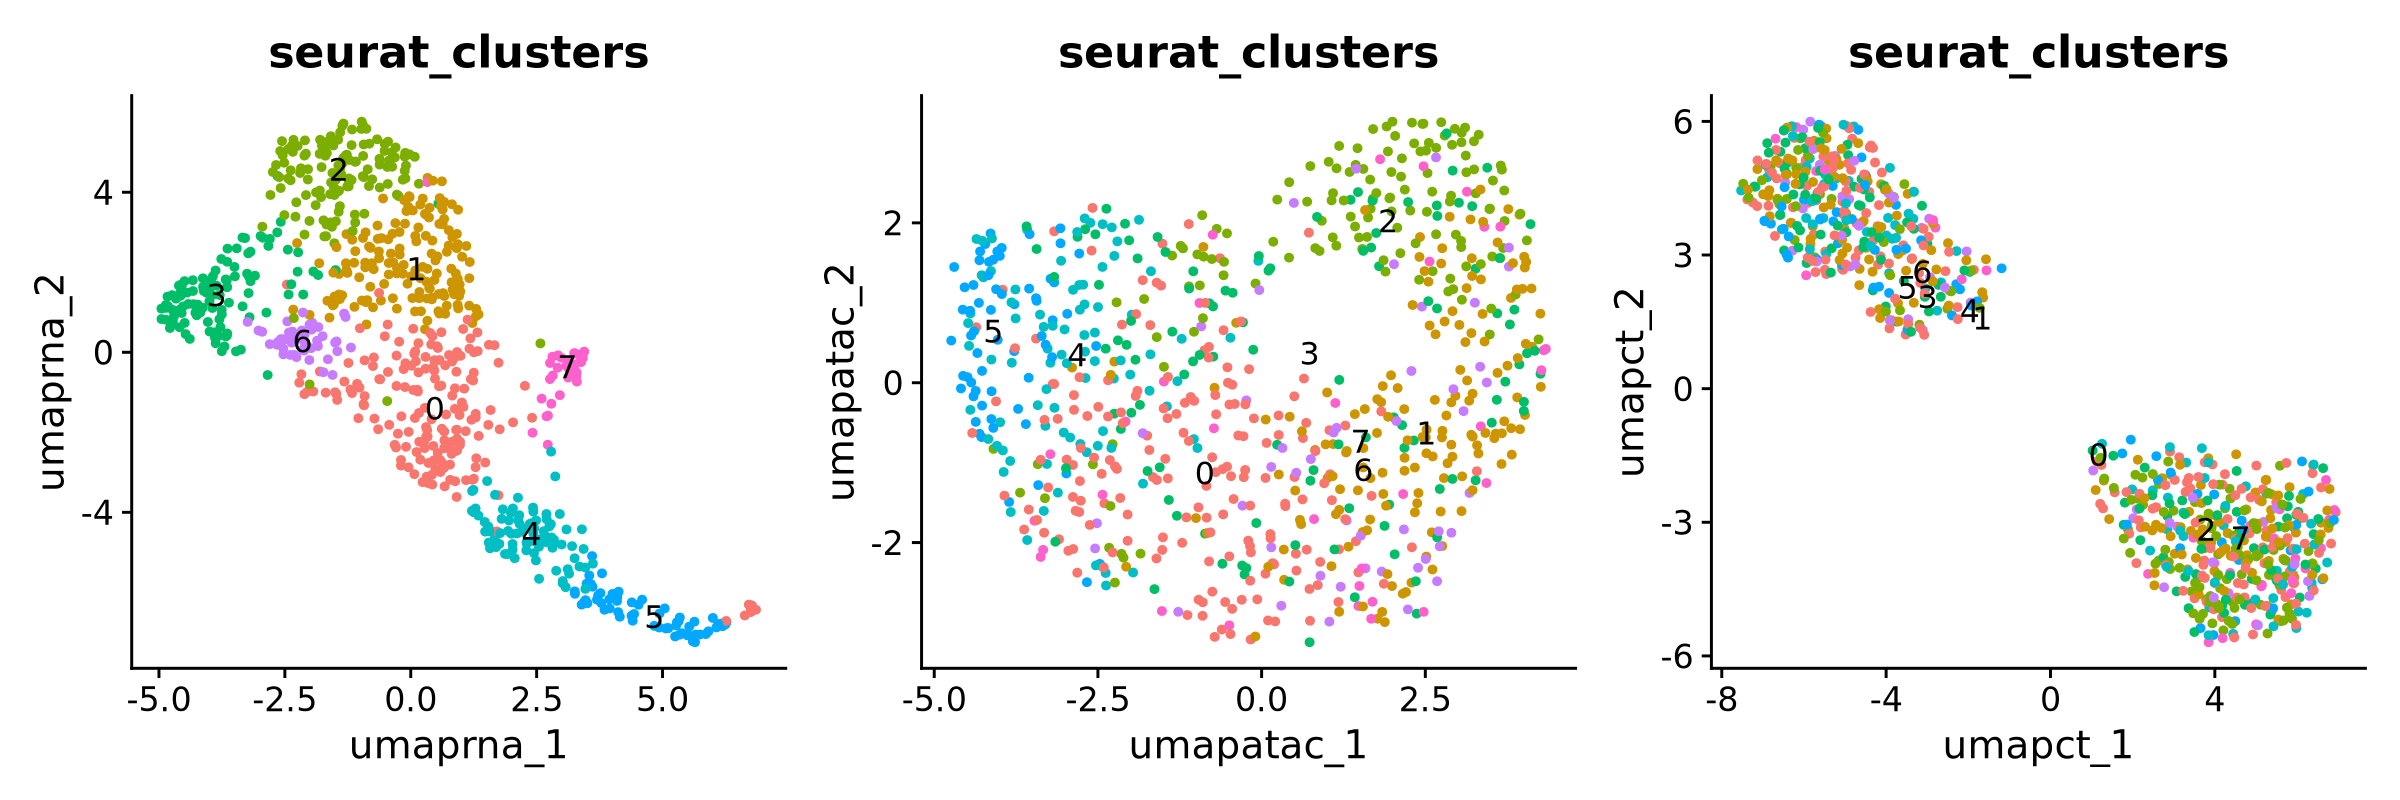

In [19]:
options(repr.plot.width=12, repr.plot.height=4,repr.plot.res=200)
a <- DimPlot(charm,reduction = "umap_rna",group.by = "seurat_clusters",label=T) + NoLegend() 
b <- DimPlot(charm,reduction = "umap_atac",group.by = "seurat_clusters",label=T) + NoLegend()
c <- DimPlot(charm,reduction = "umap_ct",group.by = "seurat_clusters",label=T) + NoLegend()

a | b | c

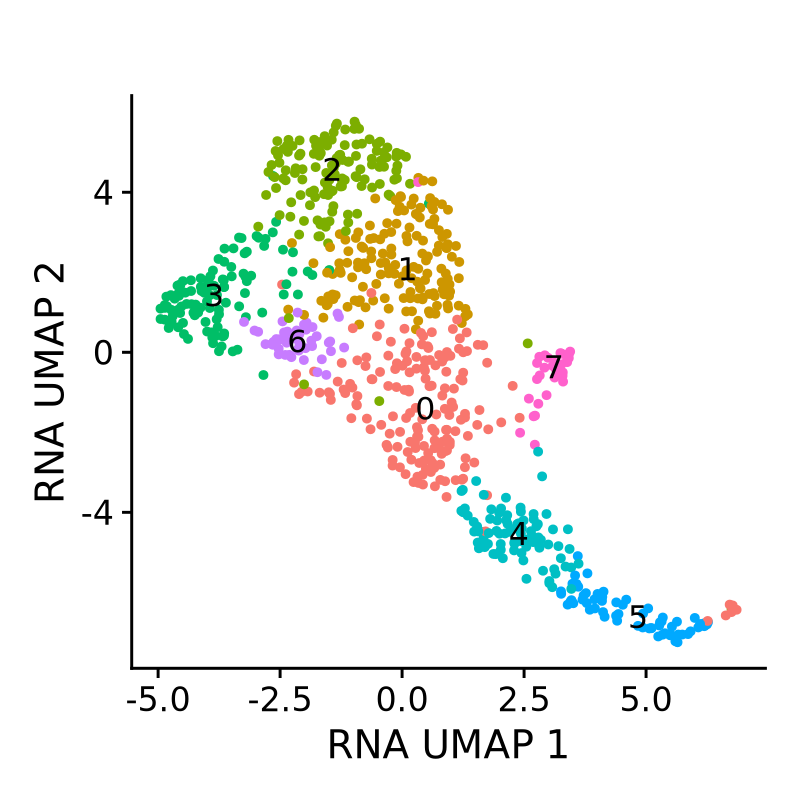

In [20]:
options(repr.plot.width=4, repr.plot.height=4,repr.plot.res=200)
p <- DimPlot(charm,reduction = "umap_rna",group.by = "seurat_clusters",label=T) + NoLegend() + xlab("RNA UMAP 1") + ylab("RNA UMAP 2") + ggtitle("")
p
p %>% ggsave(filename = "figures/mesc_umap_rna.svg",width = 4, height = 4)

In [21]:
charm

An object of class Seurat 
1203275 features across 805 samples within 6 assays 
Active assay: ct (492558 features, 492558 variable features)
 2 layers present: counts, data
 5 other assays present: rna, atac, atac_peaks, ct_peaks, SCT
 6 dimensional reductions calculated: pca_rna, umap_rna, lsi_atac, umap_atac, lsi_ct, umap_ct

## Cellcycle

In [22]:
mat = read_tsv("cdps.tsv")
mat %>% column_to_rownames("cellname") -> mat
mat = mat[,45:138]
mat = mat[rownames(charm[[]]),rev(names(mat))]

Rows: 958 Columns: 152
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr   (1): cellname
dbl (151): 0.0, 1000.0, 1090.5077326652577, 1189.2071150027211, 1296.8395546...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [23]:
charm_cdps = CreateAssayObject(t(mat))
charm[["cdps"]] = charm_cdps
DefaultAssay(charm) <- "cdps"
charm = charm%>% ScaleData() %>% RunPCA(verbose=FALSE,reduction.name = "pca_cdps",npcs=20,features = rownames(charm[["cdps"]]))
charm = RunUMAP(charm, reduction = "pca_cdps", dims = 1:5, verbose = FALSE,reduction.name = "umap_cdps")

charm = FindNeighbors(charm, reduction = "pca_cdps", dims = 1:5, verbose = FALSE,graph.name = "cdps_nn")
charm = FindClusters(charm, resolution = 0.3, verbose = FALSE,graph.name = "cdps_nn", algorithm = 3)

Centering and scaling data matrix

Warning message:
"Key 'PC_' taken, using 'pcacdps_' instead"
Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

Only one graph name supplied, storing nearest-neighbor graph only

Warning message:
"UNRELIABLE VALUE: One of the 'future.apply' iterations ('future_lapply-1') unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore"."


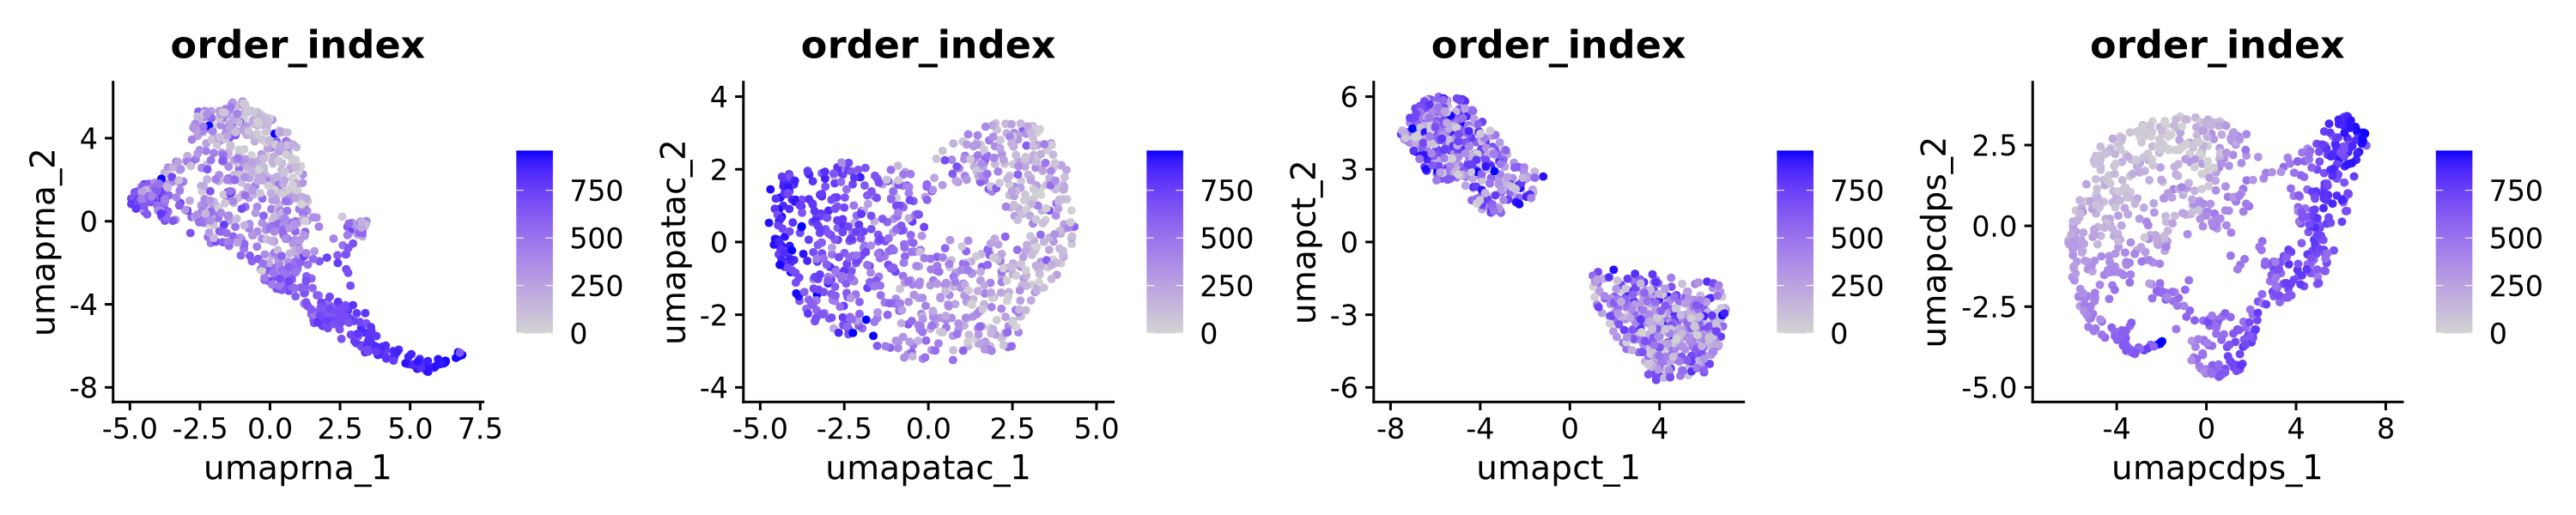

In [24]:
options(repr.plot.width=15, repr.plot.height=3,repr.plot.res=200)
a = FeaturePlot(charm,reduction = "umap_rna",features = "order_index") 
b = FeaturePlot(charm,reduction = "umap_atac",features = "order_index") 
c = FeaturePlot(charm,reduction = "umap_ct",features = "order_index") 
d = FeaturePlot(charm,reduction = "umap_cdps",features = "order_index") 
a | b | c | d

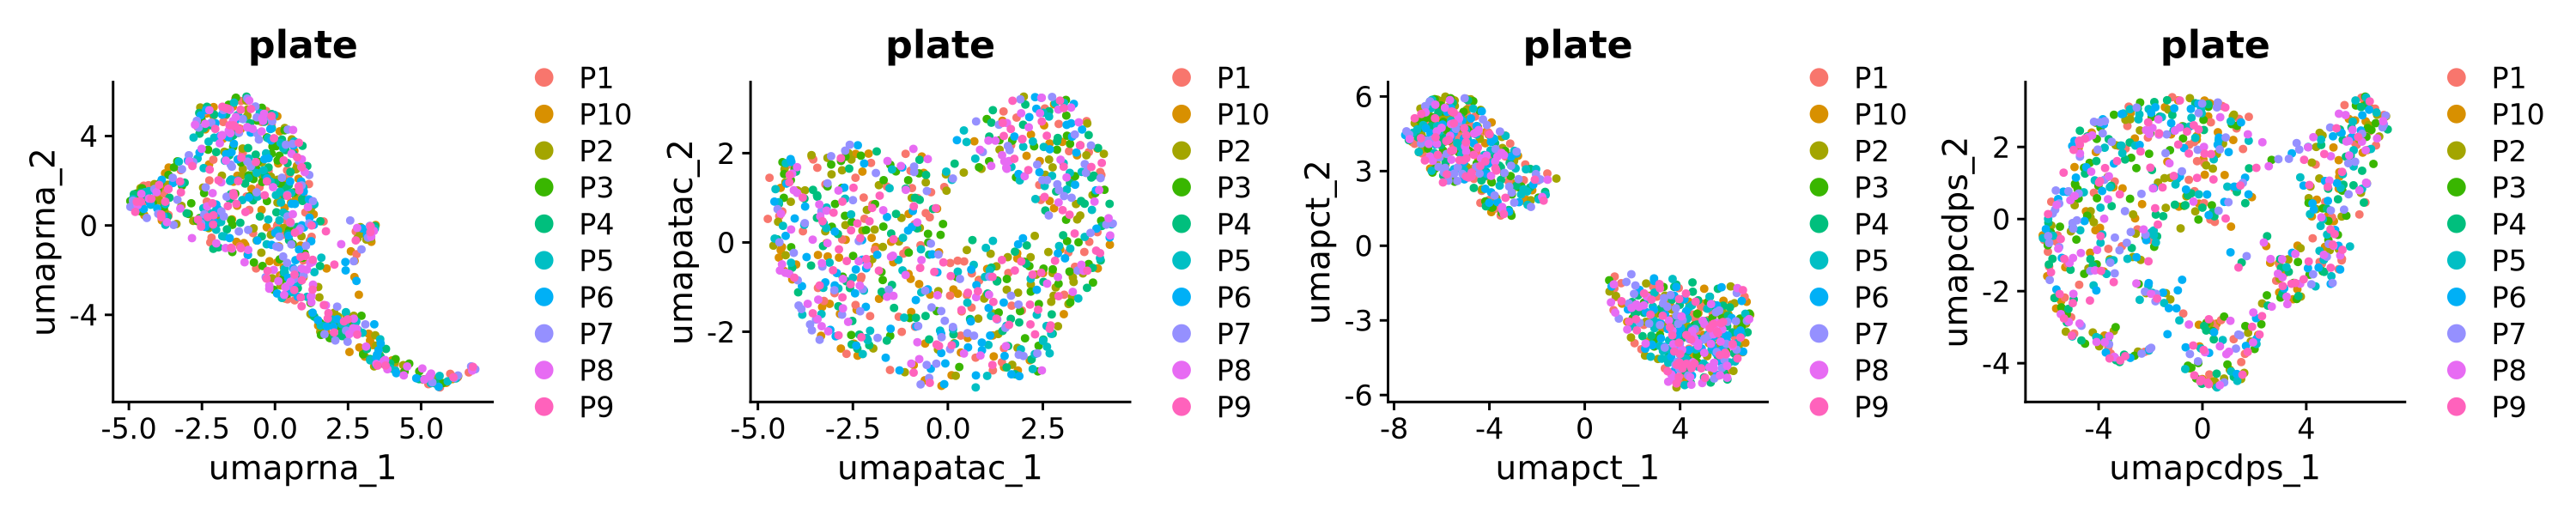

In [25]:
a = DimPlot(charm,reduction = "umap_rna",group.by = "plate") 
b = DimPlot(charm,reduction = "umap_atac",group.by = "plate") 
c = DimPlot(charm,reduction = "umap_ct",group.by = "plate") 
d = DimPlot(charm,reduction = "umap_cdps",group.by = "plate") 

a | b | c | d


In [26]:
#charm %>% saveRDS("charm.rds")

## HiRES cellcycle phasing

In [27]:
#charm <- readRDS("charm.rds")

In [28]:
charm[[]] %>% dplyr::select(1:51) -> charm@meta.data

In [29]:
cellcyclecolors = c("G0"="#762a83","G1"="#c2a5cf","Early-S"="#99d8c9","Mid-S"="#66c2a4","Late-S"="#41ae76","G2"="#238b45","M"="#ea6e34")
colors <-c("#f7fbff","#deebf7","#c6dbef","#9ecae1","#6baed6","#4292c6","#2171b5","#084594")

# 1. add G1S and G2M score
DefaultAssay(charm) <- "rna"
charm %>% NormalizeData() %>% FindVariableFeatures() %>% ScaleData() -> charm
G1S.genes = cc.genes$s.genes  %>% str_to_title()
G2M.genes = cc.genes$g2m.genes %>% str_to_title()
charm = AddModuleScore(charm, features = list(G1S.score = G1S.genes, G2M.score = G2M.genes),name = c("G1S.score", "G2M.score"))
charm@meta.data %>% dplyr::rename(G1S.score = G1S.score1,G2M.score = G2M.score2) -> charm@meta.data

Normalizing layer: counts



Finding variable features for layer counts

Centering and scaling data matrix

Warning message:
"The following features are not present in the object: Mlf1ip, not searching for symbol synonyms"
Warning message:
"The following features are not present in the object: Fam64a, Hn1, not searching for symbol synonyms"


In [30]:
tempOrderDF = charm[[]] %>% dplyr::select(cellname,near_p,mitotic_p,farAvg,repli_score,G1S.score,G2M.score)
mat = charm[["cdps"]]@data %>% as.matrix() %>% t()
set.seed(42)
temp_cell_names <- tempOrderDF %>% pull(cellname)

heatmap_mat <- mat[temp_cell_names,] %>% t() %>% as.data.frame
names(heatmap_mat) <- temp_cell_names

kmeans_res <- as.data.frame(kmeans(t(heatmap_mat),24)$cluster) %>% rownames_to_column("cellname")
names(kmeans_res) <- c("cellname","cluster")
tempOrderDF <- tempOrderDF %>% left_join(kmeans_res)

#kmeans for sub cluster
tempOrderDF_by_clusters <- list()
for (cluster_i in tempOrderDF %>% pull(cluster) %>% unique()){
    tempOrderDF_by_cluster <- tempOrderDF %>% dplyr::filter(cluster == cluster_i)
    if(dim(tempOrderDF_by_cluster)[1] <=3){
        tempOrderDF_by_cluster <- tempOrderDF_by_cluster %>% mutate(paste0("sub_c",subcluster = row_number()))
        names(tempOrderDF_by_cluster)[9] <- "sub_k_cluster"
    }
    else{
        tempOrderDF_by_cluster <- cbind(tempOrderDF_by_cluster,as.data.frame(paste0("sub_c",(tempOrderDF_by_cluster %>% dplyr::select(G1S.score,G2M.score,repli_score) %>% scale() %>% kmeans(3))$cluster)))
        names(tempOrderDF_by_cluster)[9] <- "sub_k_cluster"
    }
    tempOrderDF_by_clusters <- c(tempOrderDF_by_clusters,list(tempOrderDF_by_cluster))
}
tempOrderDF <- bind_rows(tempOrderDF_by_clusters)

#adjust order here
tempOrderDF <- tempOrderDF[sample(1:nrow(tempOrderDF)), ] %>% arrange(cluster,sub_k_cluster)

Joining with `by = join_by(cellname)`


In [31]:
#annotate_df %>% dplyr::filter(mean_G2M < -0.1,mean_G1S < -0.09,cellcycle_phase == "Early-S")

Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's fill values."
Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's fill values."
Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's fill values."
Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's fill values."


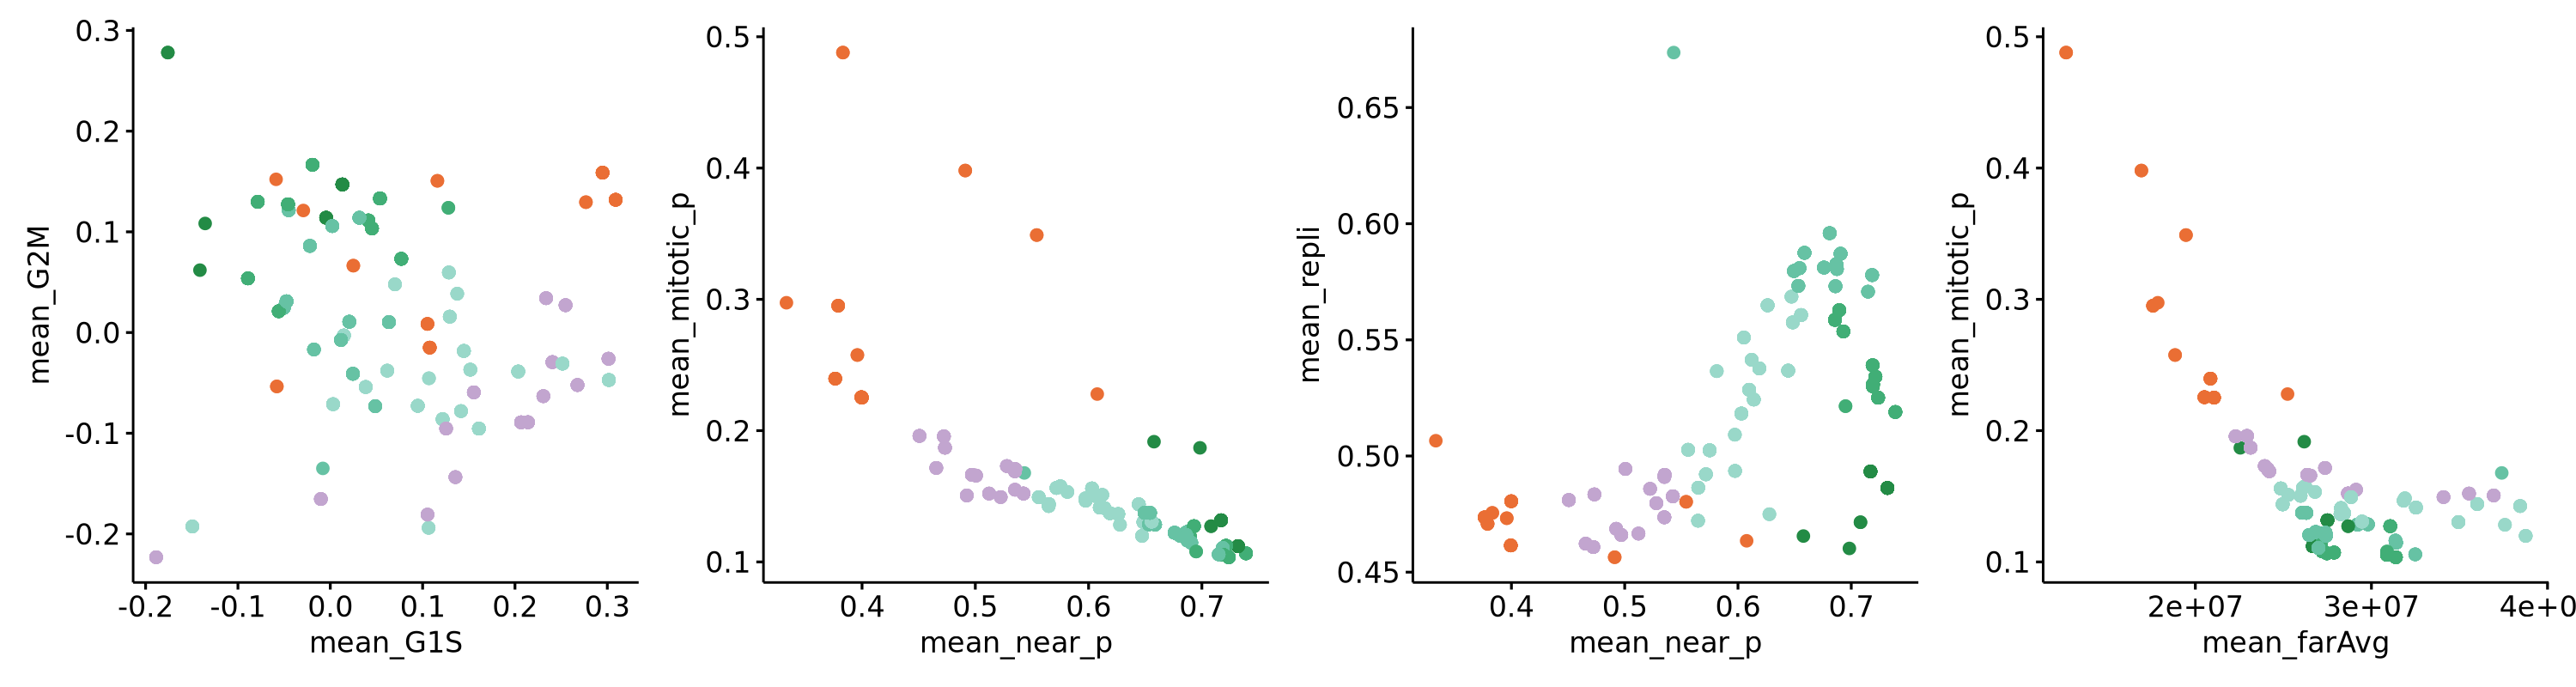

In [32]:
annotate_df = tempOrderDF %>% group_by(cluster,sub_k_cluster) %>% 
              mutate(mean_G1S = mean(G1S.score),mean_G2M = mean(G2M.score),mean_repli = mean(repli_score),mean_near_p = mean(near_p),mean_mitotic_p = mean(mitotic_p),mean_farAvg = mean(farAvg))
annotate_df %>% mutate(cellcycle_phase = ifelse(mean_mitotic_p > 0.2 | mean_farAvg < (2e+07),"M",
                                    ifelse(mean_G2M < -0.15 & mean_repli < 0.5 & mean_G1S < -0.15,"G0",
                                            ifelse(mean_near_p > 0.65 & mean_repli < 0.5 ,"G2",
                                                ifelse(mean_repli < 0.5 & mean_G1S > -0.2 & mean_G2M < 0.1 & mean_near_p < 0.55,"G1",
                                                        ifelse(mean_G1S > -0.2 & mean_G2M < 0.1 & mean_near_p < 0.66 & mean_repli < 0.57,"Early-S",
                                                            ifelse(mean_G2M > 0 & mean_near_p > 0.65& mean_repli < 0.57,"Late-S",
                                                                        ifelse(mean_repli >= 0.55,"Mid-S","G2")
                                                                ))))))) -> annotate_df

# since only very few cell in G0 and not likely to present in mESC, we merge G0 with G1
annotate_df %>% mutate(cellcycle_phase = ifelse(cellcycle_phase == "G0","G1",cellcycle_phase)) -> annotate_df

options(repr.plot.width=15, repr.plot.height=4,repr.plot.res=200)
a = annotate_df %>% ggscatter(x="mean_G1S",y="mean_G2M",color = "cellcycle_phase",palette = cellcyclecolors) + NoLegend()
b = annotate_df %>% ggscatter(x="mean_near_p",y="mean_mitotic_p",color = "cellcycle_phase",palette = cellcyclecolors) + NoLegend()
c = annotate_df %>% ggscatter(x="mean_near_p",y="mean_repli",color = "cellcycle_phase",palette = cellcyclecolors) + NoLegend()
d = annotate_df %>% ggscatter(x="mean_farAvg",y="mean_mitotic_p",color = "cellcycle_phase",palette = cellcyclecolors) + NoLegend()
a | b | c | d

In [33]:
(a|b|c|d) %>% ggsave(filename = "cellcycle_annotate_custer.svg",width = 15, height = 4)

Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's fill values."
Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's fill values."
Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's fill values."
Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's fill values."


Joining with `by = join_by(cellname)`
'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



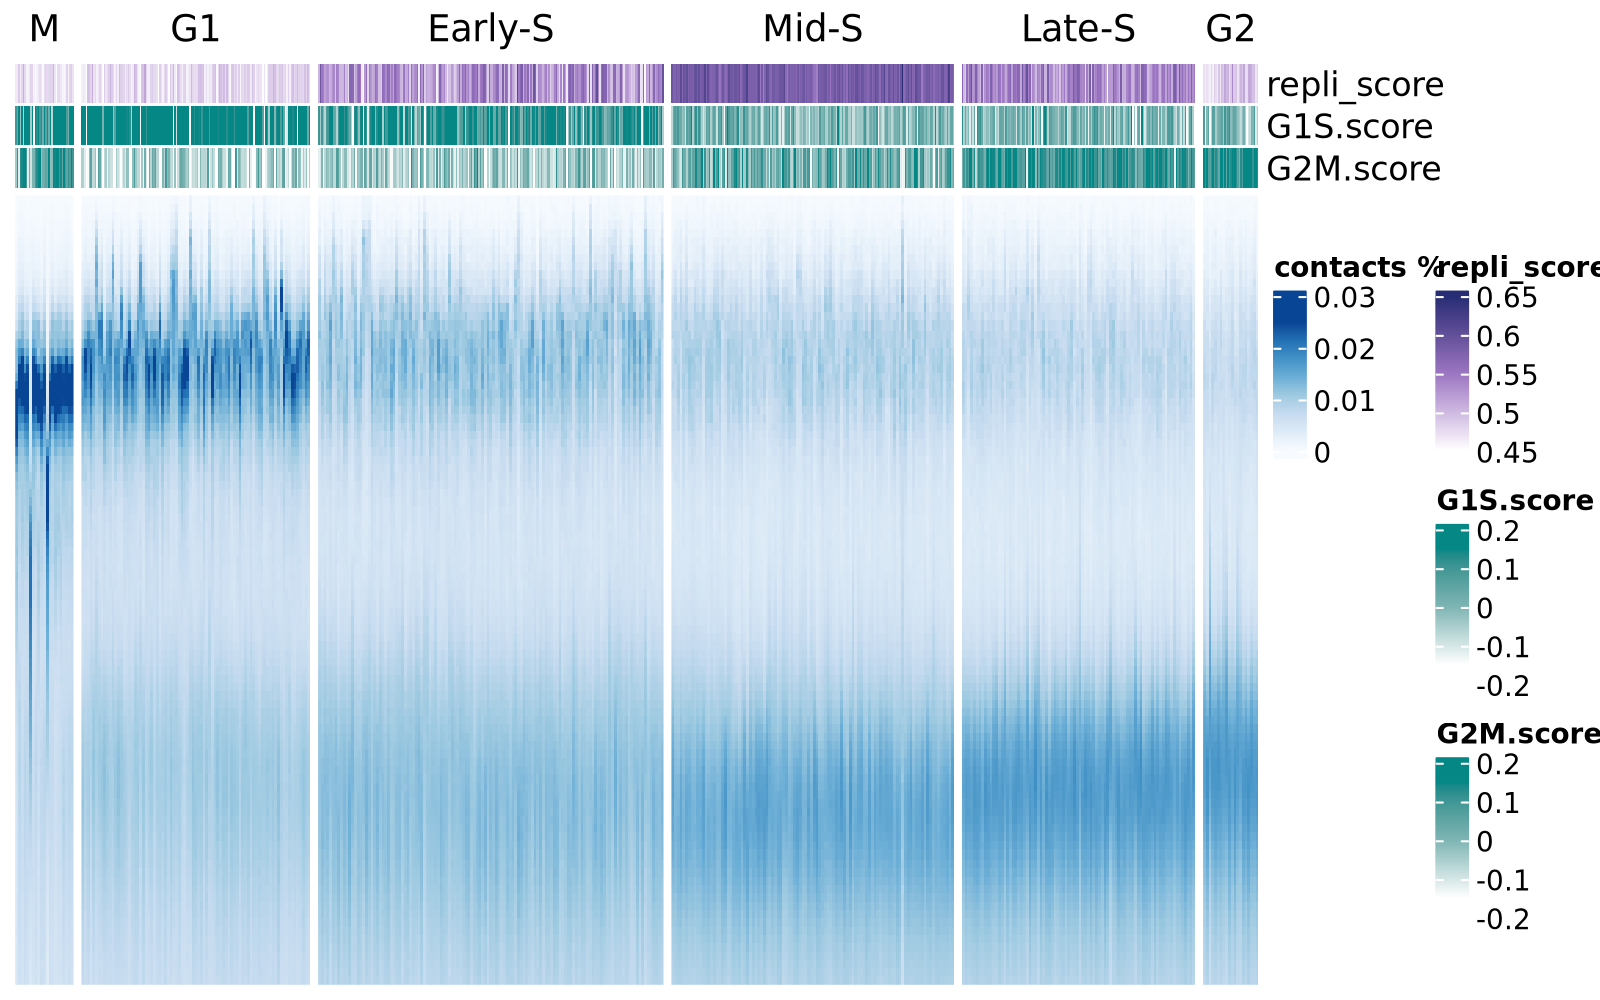

In [34]:
mat <- t(charm[["cdps"]]@data %>% as.matrix() )
set.seed(42)
colors <-c("#f7fbff","#deebf7","#c6dbef","#9ecae1","#6baed6","#4292c6","#2171b5","#084594")

tempOrderDF <- charm[[]] %>% left_join(annotate_df %>% dplyr::select(cellname,cluster,sub_k_cluster,cellcycle_phase))
#order cells by cluster
tempOrderDF$cellcycle_phase <- factor(tempOrderDF$cellcycle_phase ,levels=c("G0","M","G1","Early-S","Mid-S","Late-S","G2"))
tempOrderDF <- tempOrderDF[sample(1:nrow(tempOrderDF)), ] #%>% arrange(desc(mitotic_p))
#addjust color scale

heatmap_mat <- mat[tempOrderDF  %>% pull(cellname),] %>% t() %>% as.data.frame

names(heatmap_mat) <- tempOrderDF %>%  pull(cellname)
heatmap_mat[heatmap_mat > 0.025] <- 0.025

col_fun = colorRamp2(c(0.45, 0.55, 0.65), c("#ffffff", "#9c76c2", "#272d74"))
col_fun1 = colorRamp2(c(-0.15, 0, 0.15), c("#ffffff","#7eb5b4","#058786"))

Annodf <- tempOrderDF %>% dplyr::select(repli_score,G1S.score,G2M.score,sub_k_cluster,cluster,cellname,cellcycle_phase)
Annodf <- Annodf %>% group_by(cellcycle_phase)
topAnno <- HeatmapAnnotation(df=Annodf %>% column_to_rownames("cellname")%>% dplyr::select(repli_score,G1S.score,G2M.score) ,
                            col = list(repli_score = col_fun,G1S.score = col_fun1,G2M.score = col_fun1))

options(repr.plot.width=10,repr.plot.height=5,repr.plot.res=200)
p <- Heatmap(heatmap_mat%>% as.matrix(),cluster_rows = FALSE,cluster_columns = FALSE,col = colors,
       show_row_names = FALSE, show_column_names = FALSE,top_annotation= topAnno ,column_split= tempOrderDF %>% dplyr::select(cellcycle_phase),use_raster=TRUE,
        heatmap_legend_param = list(title = "contacts %")) #%>% suppressMessages()

options(repr.plot.width=8, repr.plot.height=5,repr.plot.res=200)
draw(p)

In [35]:
# save to pdf
pdf("figures/cdps_heatmap.pdf",width = 8,height = 5)
draw(p)
dev.off()

png 
  2

In [36]:
mat <- charm[["cdps"]]@data %>% as.matrix() 
tempOrder <- mat%>% as.data.frame %>% rownames_to_column("bin") %>%  gather(cellname,value,-bin) %>% group_by(cellname) %>% arrange(desc(value)) %>% dplyr::slice(1) %>% ungroup() %>% 
    arrange(as.numeric(bin))%>% mutate(maxbinorder =row_number()) %>% dplyr::select(cellname,maxbinorder) %>% right_join(tempOrderDF)

#tempOrder <- tempOrder %>% na.omit()
tempOrder <- tempOrder  %>% mutate(celltype = "mESC") %>%  mutate(varrepli = var(repli_score),varnearp = var(near_p),snearp=scale(near_p),sfar=scale(farAvg),varmitoticp = var(mitotic_p))
tempOrder <- tempOrder %>% group_by(celltype,cellcycle_phase) %>% 
                 mutate(order = ifelse(cellcycle_phase%in% c("Early-S"), -(mitotic_p /varmitoticp) + repli_score / varrepli,
                                    ifelse(cellcycle_phase %in% c("Mid-S"), near_p /varnearp,
                                      ifelse(cellcycle_phase %in% c("Late-S"),near_p / varnearp - repli_score / varrepli,
                                            ifelse(cellcycle_phase %in% c("G1","G0"),snearp, #+ sfar,
                                                  ifelse(cellcycle_phase %in% c("M","Unknown","G2"),maxbinorder)))))) %>% arrange(celltype,cellcycle_phase,order)
tempOrder %>% ungroup() %>% arrange(cellcycle_phase,order) %>% mutate(order=row_number()) -> tempOrder

Joining with `by = join_by(cellname)`


In [37]:
charm[[]] %>% left_join(tempOrder %>% ungroup() %>% dplyr::select(cellname,maxbinorder,cluster,sub_k_cluster,cellcycle_phase,order)) %>% mutate(temp = cellname) %>% column_to_rownames("temp") -> charm@meta.data

Joining with `by = join_by(cellname)`


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



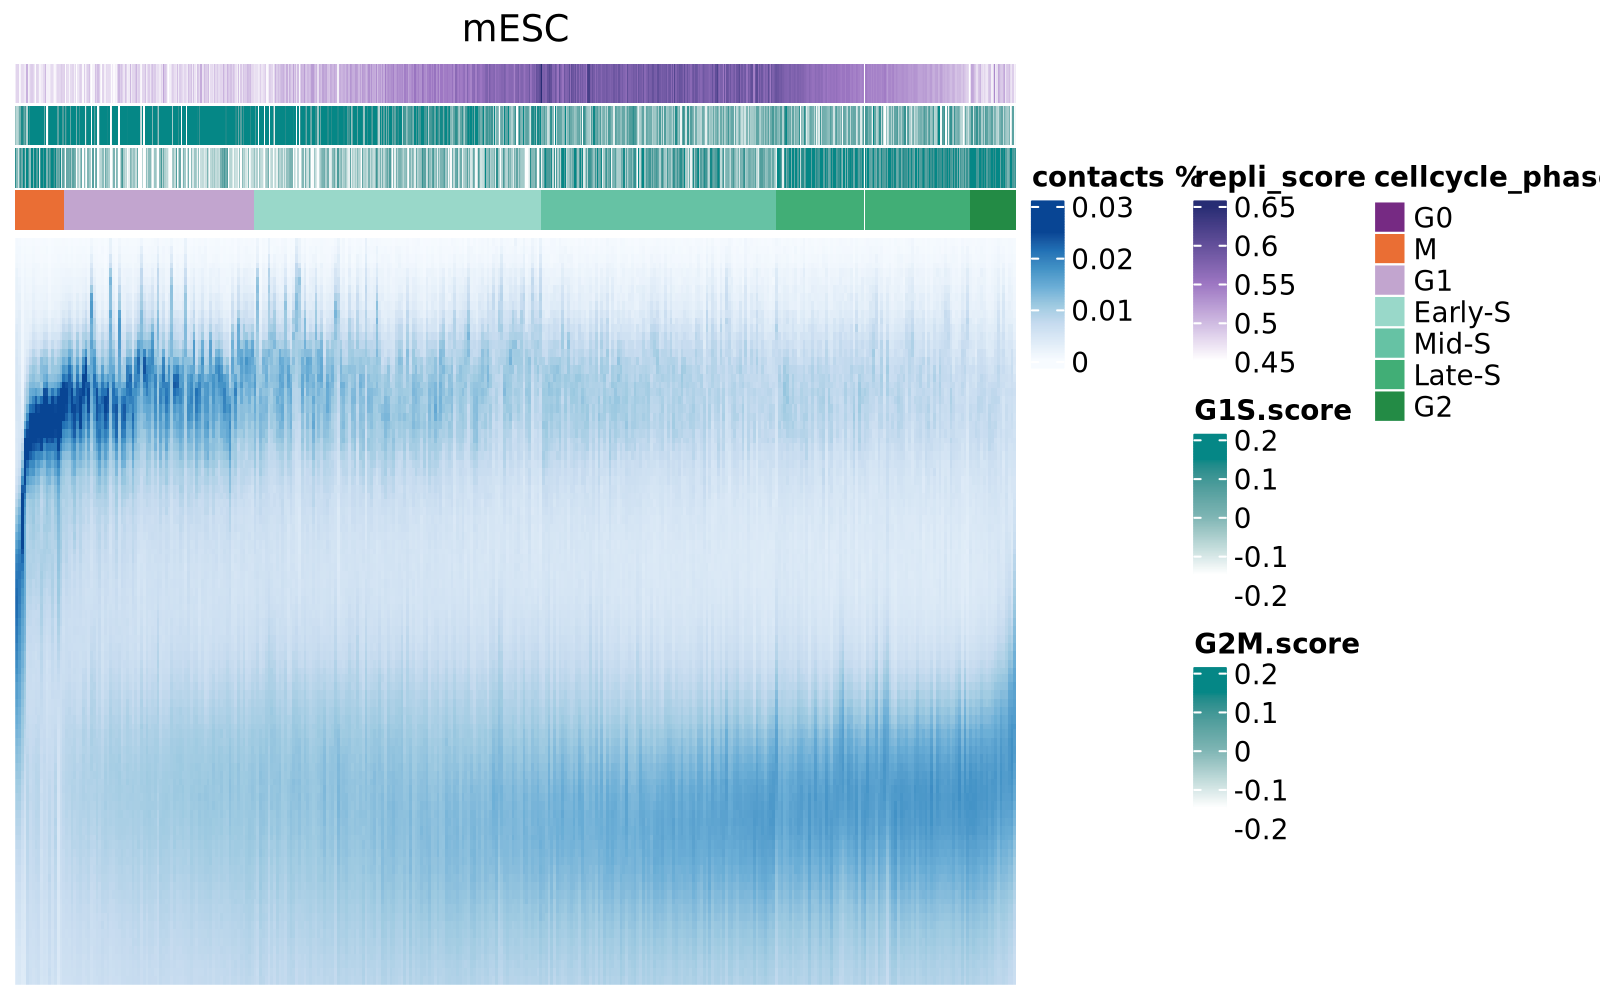

In [38]:
set.seed(42)

mat <- charm[["cdps"]]@data %>% as.matrix() 

tempOrderDF <- charm[[]] 
#tempOrderDF <- tempOrderDF %>% mutate(clusterOrder = str_replace(paste0(str_replace(celltype," ","_"),"_",cluster,"_",sub_k_cluster),"_sub_",""))
tempOrderDF$cellcycle_phase <- factor(tempOrderDF$cellcycle_phase,levels = c("G0","M","G1","Early-S","Mid-S","Late-S","G2"))
order <- tempOrderDF %>% arrange(cellcycle_phase,order) %>% pull(cellname)

tempOrderDF$cellname <- factor(tempOrderDF$cellname,levels = order)
tempOrderDF <- tempOrderDF %>% arrange(cellcycle_phase,order)

heatmap_mat <- mat[,as.character(tempOrderDF$cellname)] %>% as.data.frame

names(heatmap_mat) <- tempOrderDF$cellname
heatmap_mat[heatmap_mat > 0.025] <- 0.025

col_fun = colorRamp2(c(0.45, 0.55, 0.65), c("#ffffff", "#9c76c2", "#272d74"))
col_fun1 = colorRamp2(c(-0.15, 0, 0.15), c("#ffffff","#7eb5b4","#058786"))

Annodf <- tempOrderDF %>% dplyr::select(repli_score,G1S.score,G2M.score,sub_k_cluster,cluster,cellname,cellcycle_phase)
Annodf <- Annodf %>% group_by(cellcycle_phase) 
topAnno <- HeatmapAnnotation(df=Annodf %>% column_to_rownames("cellname")%>% dplyr::select(repli_score,G1S.score,G2M.score,cellcycle_phase) ,
                            col = list(repli_score = col_fun,G1S.score = col_fun1,G2M.score = col_fun1,cellcycle_phase=cellcyclecolors),show_annotation_name=FALSE)

options(repr.plot.width=8, repr.plot.height=5,repr.plot.res=200)
p <- heatmap_mat%>% as.matrix() %>%
    Heatmap(cluster_rows = FALSE,cluster_columns = FALSE,show_row_names = FALSE, show_column_names = FALSE,colors,
            use_raster=TRUE,top_annotation= topAnno,column_title="mESC",
            column_dend_reorder = TRUE,
               heatmap_legend_param = list(title = "contacts %"))
p

In [39]:
pdf("figures/cdps_heatmap_order.pdf",width = 8,height = 5)
draw(p)
dev.off()

png 
  2

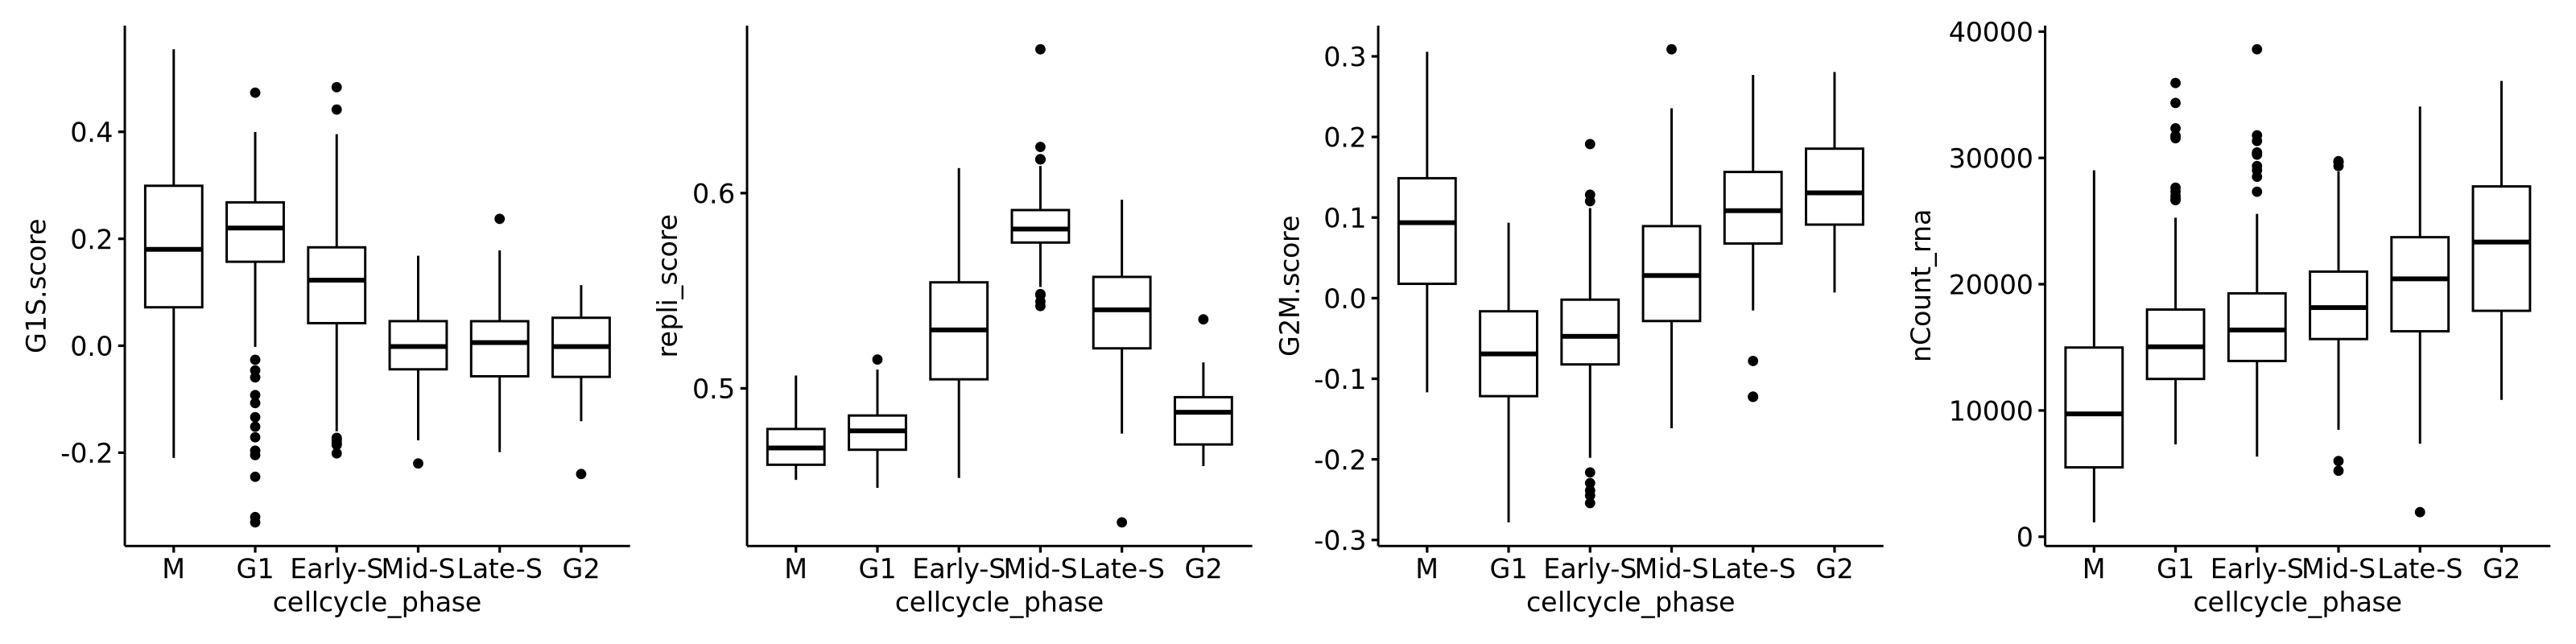

In [40]:
options(repr.plot.width=16,repr.plot.height=4,repr.plot.res=200)
b = charm@meta.data %>% group_by(cellcycle_phase) %>% ggboxplot(x="cellcycle_phase",y="repli_score")
a = charm@meta.data %>% group_by(cellcycle_phase) %>% ggboxplot(x="cellcycle_phase",y="G1S.score")
c = charm@meta.data %>% group_by(cellcycle_phase) %>% ggboxplot(x="cellcycle_phase",y="G2M.score")
d = charm@meta.data %>% group_by(cellcycle_phase) %>% ggboxplot(x="cellcycle_phase",y="nCount_rna")
a | b | c | d

In [41]:
charm[[]] %>% write_tsv("../data/metadata/metadata.tsv")

In [42]:
charm[[]] %>% dplyr::select(cellname,nCount_rna,nFeature_rna,nCount_atac,nCount_ct) %>% summary()

   cellname           nCount_rna     nFeature_rna   nCount_atac   
 Length:805         Min.   : 1141   Min.   : 921   Min.   :10141  
 Class :character   1st Qu.:14194   1st Qu.:4903   1st Qu.:44758  
 Mode  :character   Median :17163   Median :5432   Median :52302  
                    Mean   :17610   Mean   :5397   Mean   :52162  
                    3rd Qu.:20903   3rd Qu.:6028   3rd Qu.:59825  
                    Max.   :38602   Max.   :8015   Max.   :79385  
   nCount_ct     
 Min.   : 20610  
 1st Qu.: 87615  
 Median :103765  
 Mean   :106481  
 3rd Qu.:123752  
 Max.   :198786  

In [43]:
charm[[]] %>% dplyr::filter(`5k` < 2) %>% nrow()

[1] 720

In [44]:
charm %>% saveRDS("charm.rds")